## Script to quantify parameter sensitivity and interactions 
##### Community Land Model example
##### - Leaf Area Index (LAI) averaged over plant functional types (PFTs)

##### Linnia Hawkins 5/4/2023

##### authenticate github every.single.time:  gh-scoped-creds

In [7]:
#! mamba env update -f environment.yml

In [5]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from esem import gp_model
from esem.utils import get_random_params
from sklearn.metrics import mean_squared_error, r2_score
#from scipy import stats
import gpflow

from SALib.sample import fast_sampler
from SALib.analyze import fast

In [6]:
def normalize(var):
    return (var-min(var))/(max(var)-min(var))

def unnormalize(norm_var,raw_var):
    return norm_var*np.array(max(raw_var)-min(raw_var)) + np.array(min(raw_var))

In [8]:
#read in LAI metrics
ds = xr.open_dataset('TLAI.nc')
pft_LAI = ds.TLAI_pft_avg_2003

In [9]:
# get parameter sets 
lhckey = 'lhc220926.txt'
df = pd.read_csv(lhckey)
ppe_params = df.drop(columns='member')
num_params = len(ppe_params.columns)

In [10]:
pfts = pd.read_csv('pft_names.csv')
pfts = pfts['pft_names']

### Train Gaussian Process Emulators for each PFT

In [13]:
# Define kernel
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,32))
kernel = kernel_linear + kernel_matern32

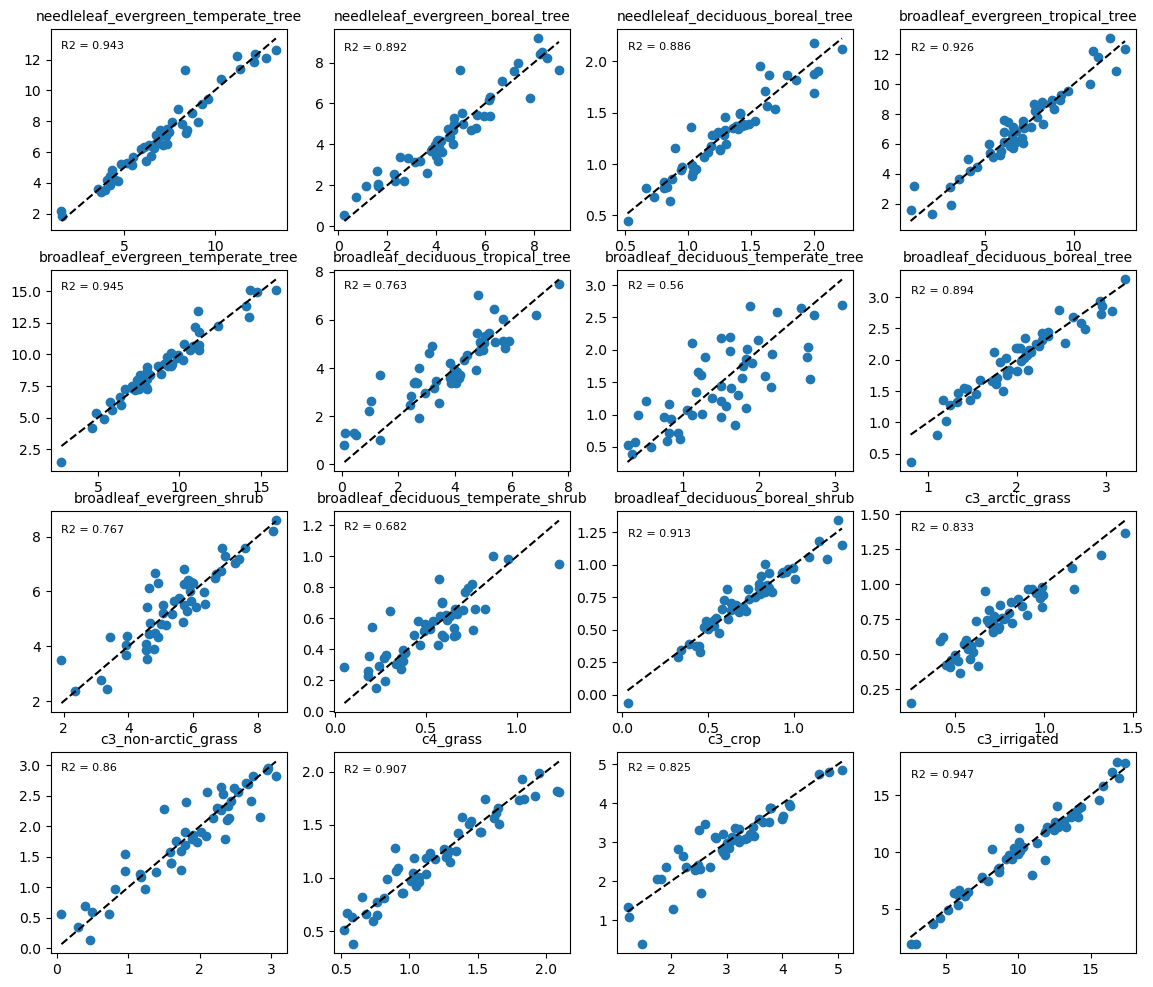

In [12]:
# Train individual emulators for each PFT
plt.figure(figsize=[14,12])
plt.rcParams.update({'font.size': 10})

emulator_dict = {}
keys = range(1,17)

for pft in range(1,17):
    
    var_raw = pft_LAI.isel(pft=pft).compute()
    var = normalize(var_raw)

    n_test = 50 # number of ensemble members to test emulator
    Y = var[1:].values # target variable excluding default model [0]

    X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
    y_test, y_train = Y[:n_test], Y[n_test:]

    emulator = gp_model(np.array(X_train),np.array(y_train),kernel = kernel)
    emulator.train()

    emulator_dict[keys[pft-1]] = emulator
    
    #plot emulator validation
    y_pred, y_pred_var = emulator.predict(X_test.values)
    rms = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test,y_pred)
    
    y_test_raw = unnormalize(y_test,var_raw)

    ax = plt.subplot(4,4,pft)
    ax.plot([min(y_test_raw),max(y_test_raw)],[min(y_test_raw),max(y_test_raw)],c='k',linestyle='--',label='1:1 line')
    ax.scatter(y_test_raw,unnormalize(y_pred,var_raw))
    ax.text(min(y_test_raw),max(y_test_raw)*0.95,'R2 = '+str(np.round(r2,3)),fontsize=8)
    ax.set_title(pfts[pft],fontsize = 10)

#plt.savefig('PFT_emulator_eval_GM-AM-LAI.png',dpi=200)

### One-at-a-time Sensitivity

In [14]:
n=21
s = np.linspace(0,1,n)
unif = pd.concat([pd.DataFrame(np.tile(0.5,n))]*num_params,axis=1) # hold all parameters at median value
unif.columns = ppe_params.columns
#unif['leafcn'] = np.tile(0.8,n) # change individual parameter default setting for OAAT

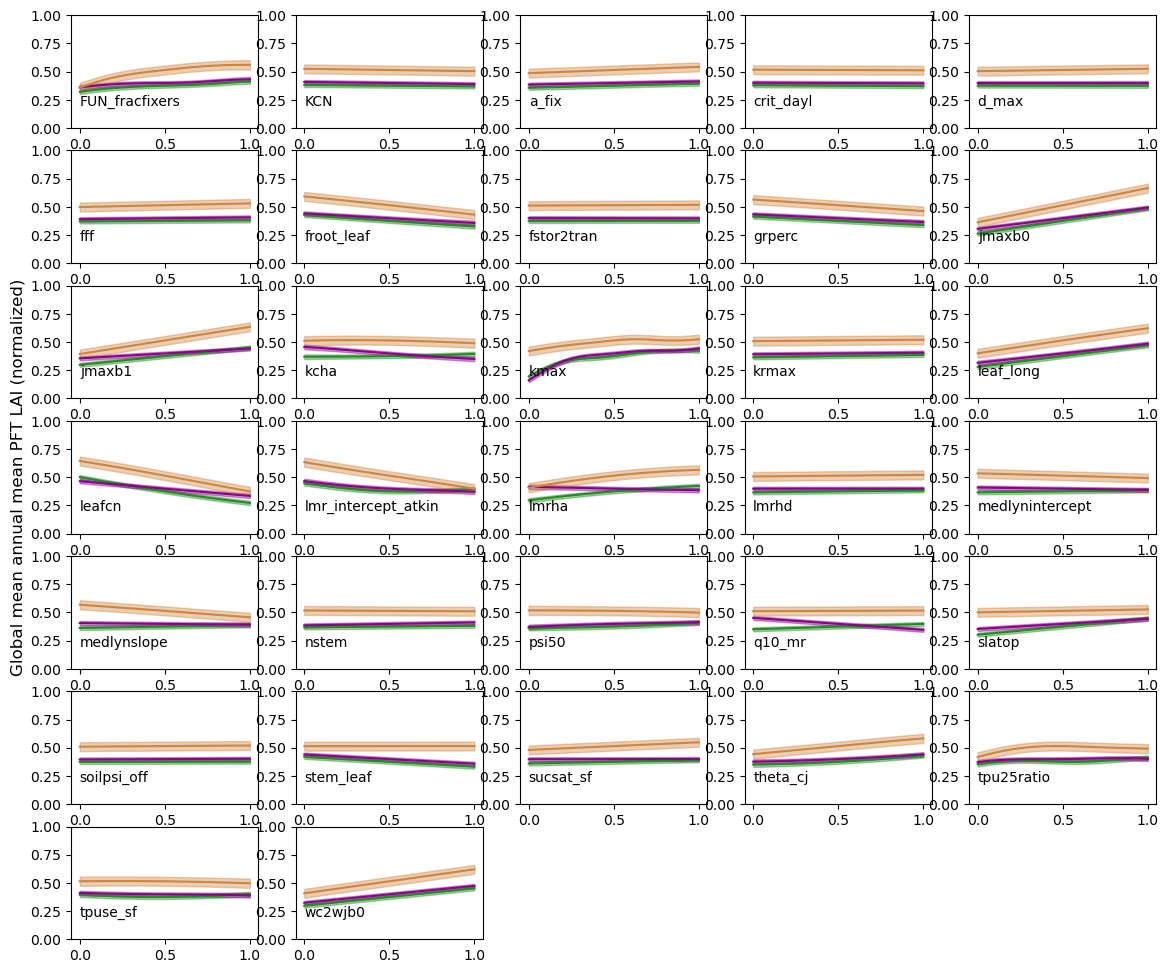

In [15]:
plt.figure(figsize=[14,12])

sample = unif
for i, p in enumerate(ppe_params.columns):
    
    ax=plt.subplot(7,5,i+1)
    sample[p] = s
    oaat, v = emulator_dict[1].predict(sample)
    sd = v**0.5
    sample[p] = np.tile(0.5,n) # set column back to median
    ax.fill_between(s, oaat-sd, oaat+sd,color='forestgreen',alpha=0.4) # shade three standard deviations
    ax.plot(s,oaat,c='forestgreen',label='NL')
    
    sample[p] = s
    oaat, v = emulator_dict[4].predict(sample)
    sd = v**0.5
    sample[p] = np.tile(0.5,n) # set column back to median
    ax.fill_between(s, oaat-sd, oaat+sd,color='darkmagenta',alpha=0.4) # shade three standard deviations
    ax.plot(s,oaat,c='darkmagenta',label='BL')
    
    sample[p] = s
    oaat, v = emulator_dict[13].predict(sample)
    sd = v**0.5
    sample[p] = np.tile(0.5,n) # set column back to median
    ax.fill_between(s, oaat-sd, oaat+sd,color='peru',alpha=0.4) # shade three standard deviations
    ax.plot(s,oaat,c='peru',label='C3')
    
    
    plt.text(0,0.2,p)
    #plt.plot([0,1],[default, default],'--',c='k')
    ax.set_ylim([0,1])
    if i == 15:
        plt.ylabel('Global mean annual mean PFT LAI (normalized)',fontsize=12)
    
#plt.savefig('param_sens/OAAT_sensitivity_PFT1-4-13_gmLAI.png',dpi=200)

### Pairwise interactions

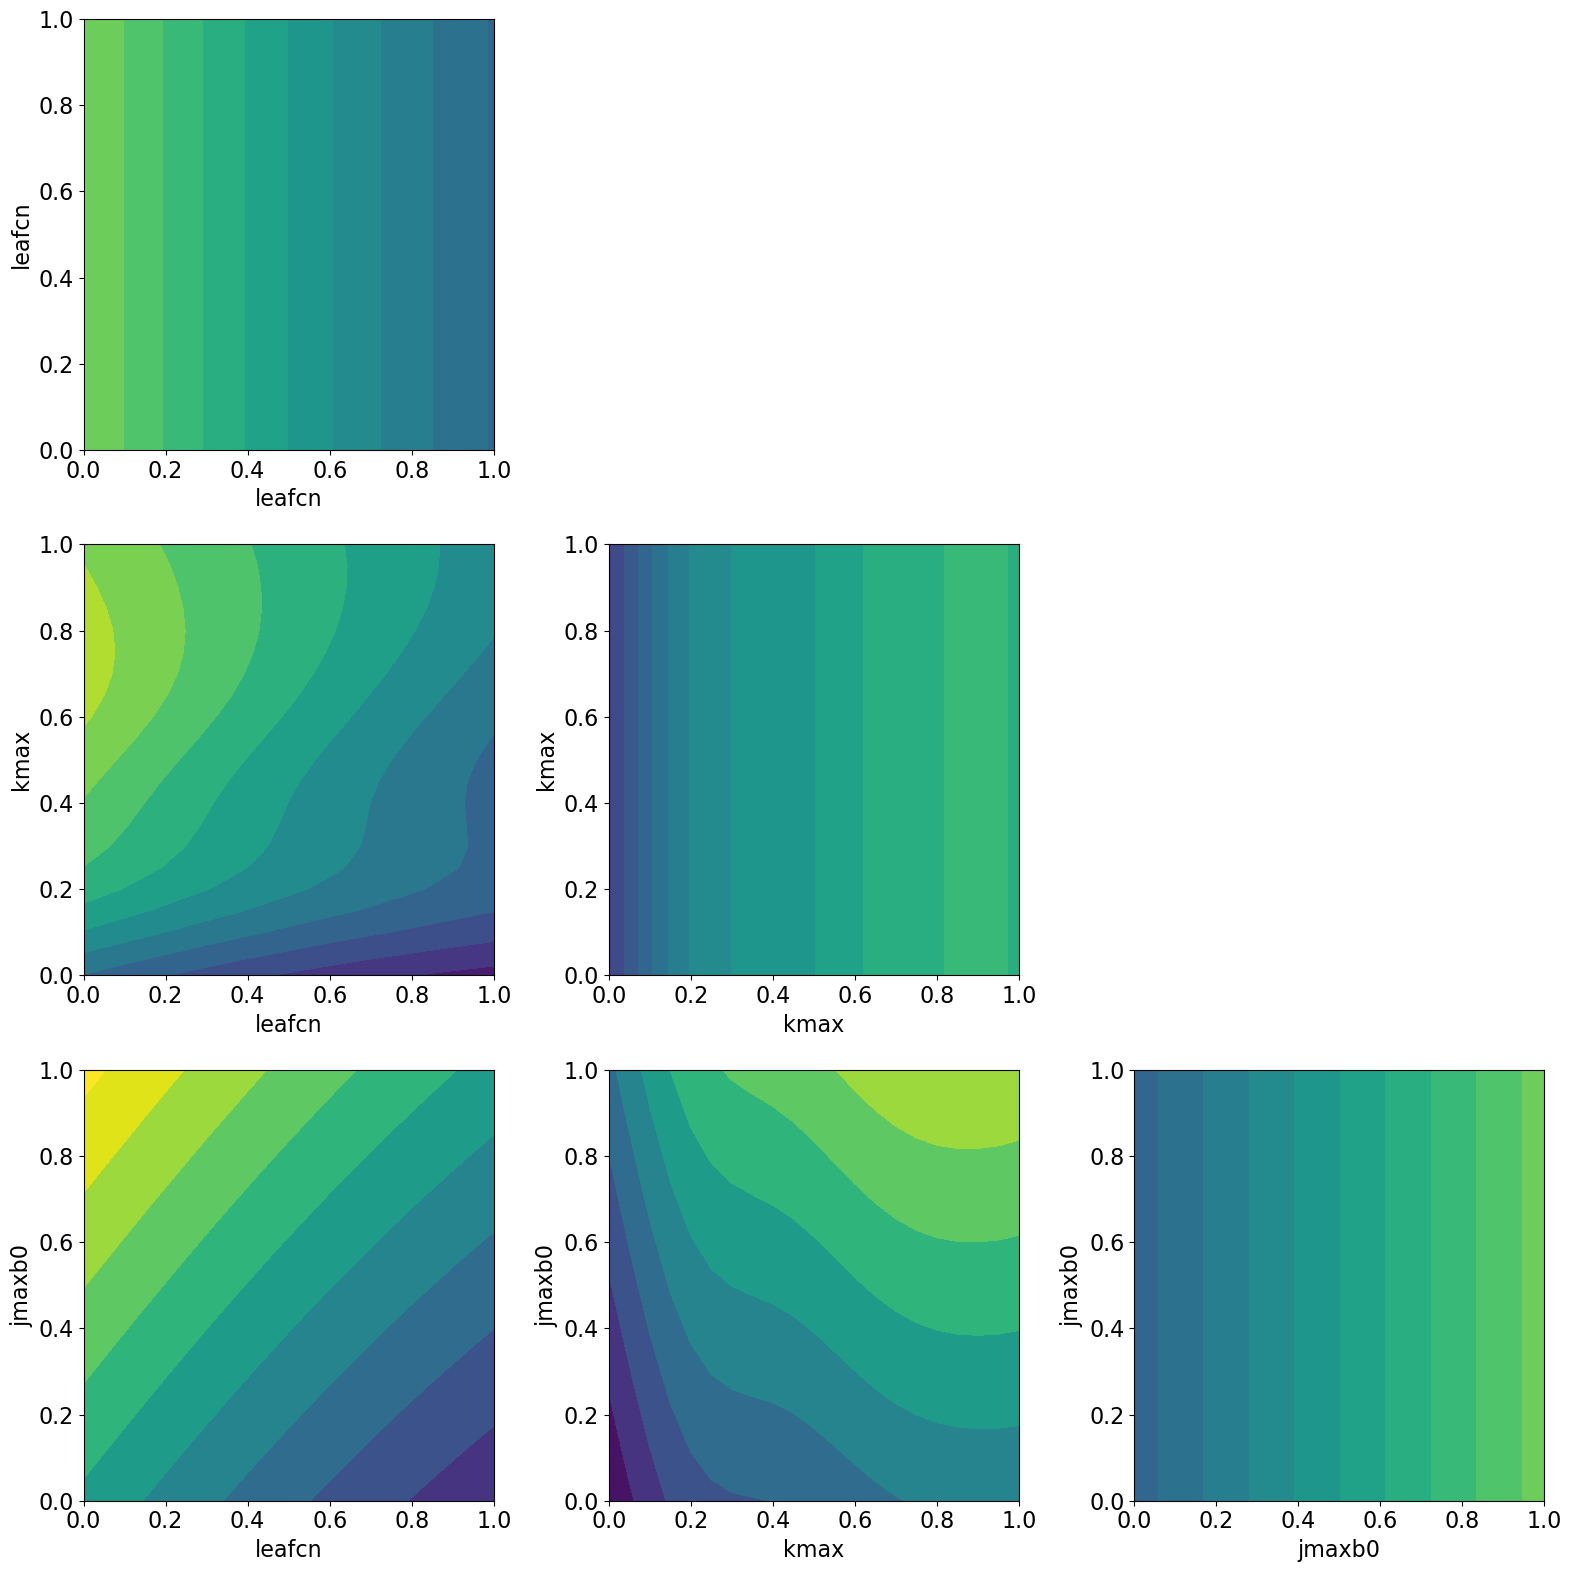

In [52]:
# pairwise interactions

fig = plt.figure(figsize=[16,16])
plt.rcParams.update({'font.size': 16})

param_list = ['leafcn','kmax','jmaxb0']

n=21
s = np.linspace(0,1,n)

pft = 1
ix = 1
for i, ip in enumerate(param_list):
    
    for j, jp in enumerate(param_list):
        
        if j>i :
            ix = ix+1
        else:

            ax =plt.subplot(3,3,ix)
            out = np.empty((n,n))
            for m in range(n):
                unif = pd.concat([pd.DataFrame(np.tile(0.5,n))]*num_params,axis=1) # hold all parameters at median value
                unif.columns = ppe_params.columns
                unif[ip] = np.tile(s[m],n)
                unif[jp] = s

                vals, _ = emulator_dict[pft].predict(unif)

                out[m,:] = vals

            contours = ax.contourf(s, s, out, 9, vmin=0.1, vmax=0.6)
            ax.set_xlabel(jp)
            ax.set_ylabel(ip)
            ix = ix+1
            

#fig.colorbar(contours,label='Leaf Area Index',pad = 0.2)
#fig.subplots_adjust(right=0.6)
#cbar_ax = fig.add_axes([0.66, 0.25, 0.05, 0.5])
#fig.colorbar(contours, cax=cbar_ax,label='Leaf Area Index')

plt.tight_layout()
#plt.savefig('test_

### Fourier Amplitude Sensitivity

In [28]:
# fourier amplitude sensitivity test w/emulator
problem = {
    'names': ppe_params.columns,
    'num_vars': num_params,
    'bounds': [[0, 1]],
}

sample = fast_sampler.sample(problem, 1000, M=4, seed=None)

pft = 1
Y, _ = emulator_dict[pft].predict(sample)
FAST = fast.analyze(problem, Y, M=4, num_resamples=100, conf_level=0.95, print_to_console=False, seed=None)
sens = pd.DataFrame.from_dict(FAST)
sens.index = sens.names
df_sens = sens.sort_values(by=['S1'],ascending=False)

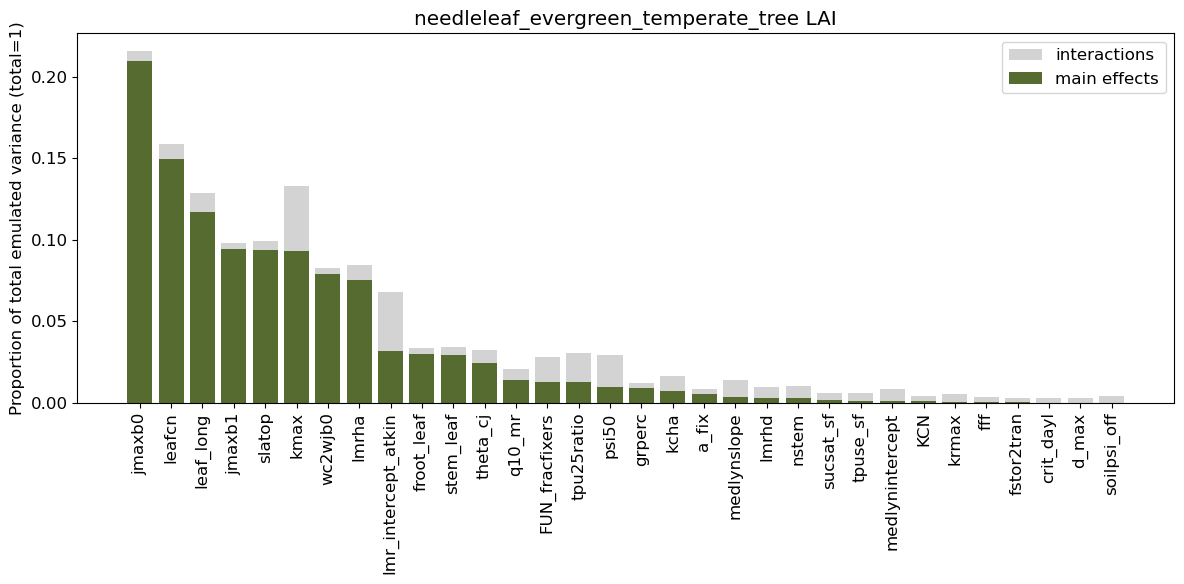

In [32]:
plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

ax = plt.subplot(1,1,1)
ax.bar(df_sens.names,df_sens['ST'],color='lightgrey',label='interactions')
ax.bar(df_sens.names,df_sens['S1'],color='darkolivegreen',label='main effects')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.legend(loc='upper right')
plt.ylabel('Proportion of total emulated variance (total=1)')
plt.title(str(pfts[pft])+' LAI')
plt.tight_layout()

### FAST analysis for all PFTs

In [11]:
problem = {
    'names': ppe_params.columns,
    'num_vars': num_params,
    'bounds': [[0, 1]],
}

sample = fast_sampler.sample(problem, 1000, M=4, seed=None)

In [12]:
for pft in range(1,17):
    Y, _ = emulator_dict[pft].predict(sample)
    FAST = fast.analyze(problem, Y, M=4, num_resamples=100, conf_level=0.95, print_to_console=False, seed=None)
    if pft ==1:
        FAST_sens = pd.DataFrame.from_dict(FAST['S1'])
    else:
        FAST_sens[pft] = FAST['S1']
        
FAST_sens.index = pd.DataFrame.from_dict(FAST).names
FAST_sens.columns = pfts[1:17]

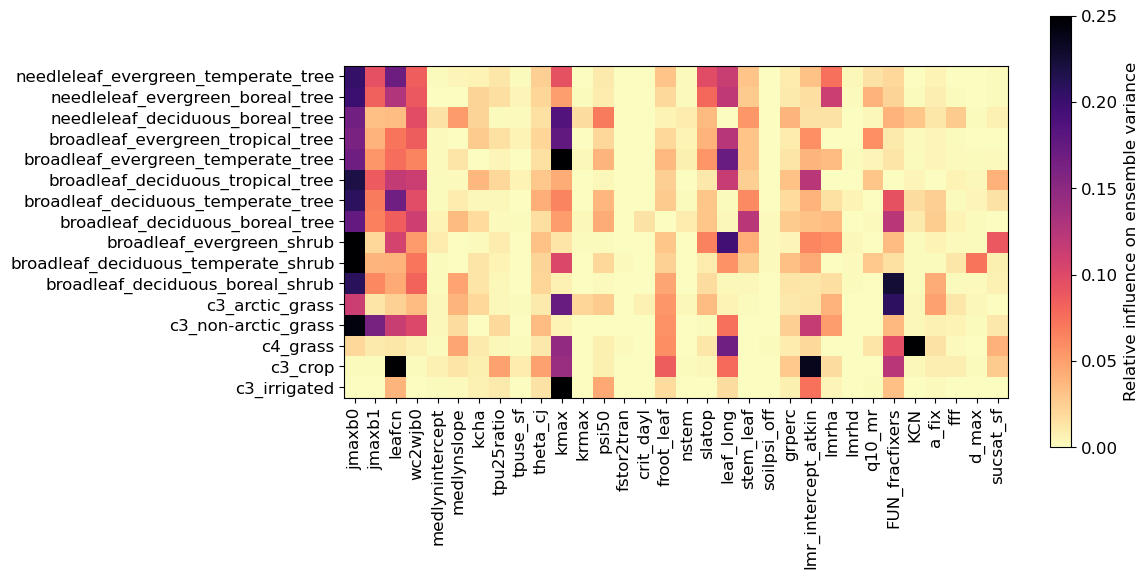

In [27]:
# heatmap of all global mean variables
params = ['jmaxb0', 'jmaxb1', 'leafcn', 'wc2wjb0', 'medlynintercept', 'medlynslope', 'kcha', 'tpu25ratio', 'tpuse_sf', 'theta_cj',
          'kmax', 'krmax', 'psi50', 'fstor2tran','crit_dayl', 'froot_leaf', 'nstem', 'slatop','leaf_long', 'stem_leaf', 'soilpsi_off',
          'grperc', 'lmr_intercept_atkin', 'lmrha', 'lmrhd', 'q10_mr', 'FUN_fracfixers', 'KCN', 'a_fix', 'fff', 'd_max', 'sucsat_sf']

FAST_sens = FAST_sens.reindex(params)

var_names = FAST_sens.columns
plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
im = ax.imshow(FAST_sens.transpose(),cmap='magma_r',vmin=0,vmax=0.25)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(params)), labels=params)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_yticks(np.arange(len(var_names)), labels=var_names)

cbar = plt.colorbar(im)
cbar.set_label("Relative influence on ensemble variance")
plt.tight_layout()
#plt.savefig('../figs/param_sens/FAST_sensitivity_GM-AM-LAI-PFT_heatmap.png',dpi=200)